# Introduction

__Context:__

* Data : $X \in \mathbb{R}^d$ 


* Classes : $Y \in \{-1,1\}$

* Classifier :
$g^*(x) = \left\{\begin{array}{ll}1 & if\quad\mathbb{P}(Y = 1 | X = x) >\mathbb{P}(Y = -1 | X = x) \\-1 & else\end{array}\right.$

* sample size : $n$

__Hypothesis:__

* $X|Y=1\sim \mathcal{N}(\mu_+, \Sigma)$

* $X|Y=-1\sim \mathcal{N}(\mu_-, \Sigma)$

__Results:__


$g^*(x) = \left\{\begin{array}{ll}1 & if \quad h(x)+b>0\\-1 & else\end{array}\right.$

with:

$h(x) = (\mu_+ - \mu_-)^T\Sigma^{-1}x$

$b =\frac{1}{2}(\mu_- \Sigma^{-1}\mu_- -\mu_+ \Sigma^{-1}\mu_+) +  log(\frac{\pi_+}{\pi_-})$

$\pi_i = \mathbb{P}(Y=i)$

__Maximum likelihood estimate:__

$\hat{\pi_i} = \frac{1}{n}\#[Y = i]$

$\hat{\mu_i} = \frac{1}{\#[Y = i]}\sum_{Y_j=i}X_j$

$\hat{\Sigma_i} = \frac{1}{n}\sum_{j=1}^{n}(X_j-\overline{X_n})(X_j-\overline{X_n})^T$ 

# Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

In [31]:
class LDA(BaseEstimator, LinearClassifierMixin):
    """
        LDA classifier for two classes (-1,1)
    """
    def __init__(self, prior=None):
        """
            prior: wether to use prior in the intercept. Default is false.
        """
        self.prior = prior
        self.coef = None
        self.intercept = None
        
    def fit(self, X, y):
        #X data numpy array size (n,p)
        #Y class numpy array size (n,)
        cov = np.cov(X.T, bias=2)
        invcov = np.linalg.inv(cov)
        mu1 = X[y==1, :].mean(axis=0)
        mu2 = X[y==-1, :].mean(axis=0)
        if not self.prior:
            pi1, pi2 = 0.5, 0.5
        else:
            pi1, pi2 = np.mean(y == 1), np.mean(y == -1)
        self.coef = invcov.dot(mu1-mu2)
        self.intercept = 0.5*(mu2.dot(invcov.dot(mu2)) - mu1.dot(invcov.dot(mu1))) + np.log(pi1/pi2)
        return self

    def decision_function(self, X):
        return X.dot(self.coef) + self.intercept

    def predict(self, X):
        return np.sign(self.decision_function(X))

# Exemple

In [12]:
#2d plot function
def plot_2dX_Y(X, Y, ax=plt):
    X1 = X[Y == 1]
    X2 = X[Y == -1]
    ax.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    ax.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")

In [13]:
# plot border from clf
def plot_border(clf, data=None, num=200, label=None,ax=plt):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.001)
    ind_sort = np.argsort(y[ind])
    ax.plot(x[ind][ind_sort], y[ind][ind_sort], label=label, linewidth=2)

In [29]:
def get_metrics(clf,X,Y):
    """
        Input:
            clf: binary classifier with a method predict_function
            data: (X)
            classes: (Y) consider that Y=1 is 'yes class' and Y=-1 is 'No class'
    """
    pred = clf.predict(X)
    TP = ((pred == 1) & (Y == 1)).sum()
    TN = ((pred == -1) & (Y == -1)).sum()
    FP = ((pred == 1) & (Y == -1)).sum()
    FN = ((pred == -1) & (Y == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    prec = TP/ (TP + FP)
    recall = TP / (TP + FN)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',TP)
    print('True Negative:',TN)
    print('False Positive:',FP)
    print('False Negative:',FN)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [40]:
#generate data
p = 2;
n = 1000;
mu1 = np.random.randn(p)
mu2 = np.random.randn(p)
A = np.random.rand(p,p)
sigma = np.dot(A,A.transpose())

n1 = np.random.randint(int(n*0.1),int(n*0.9));
n2 = n - n1;
X1 = np.random.multivariate_normal(size=n1,mean=mu1,cov=sigma)
X2 = np.random.multivariate_normal(size=n2,mean=mu2,cov=sigma)

Y1 = np.ones(n1)
Y2 = -np.ones(n2)
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

In [48]:
#train set and test set
data = np.c_[X,Y]
np.random.shuffle(data)
X_train = data[:int(n *0.9),0:p]
Y_train = data[:int(n *0.9),p]
X_test = data[int(n *0.9):,0:p]
Y_test = data[int(n *0.9):,p]

In [49]:
#compute model
lda = LDA()
lda.fit(X_train, Y_train)
print("LDA parameters:")
print(lda.coef / np.linalg.norm(lda.coef), lda.intercept / np.linalg.norm(lda.coef))

LDA parameters:
[ 0.83142167 -0.55564197] 0.23536911351837767


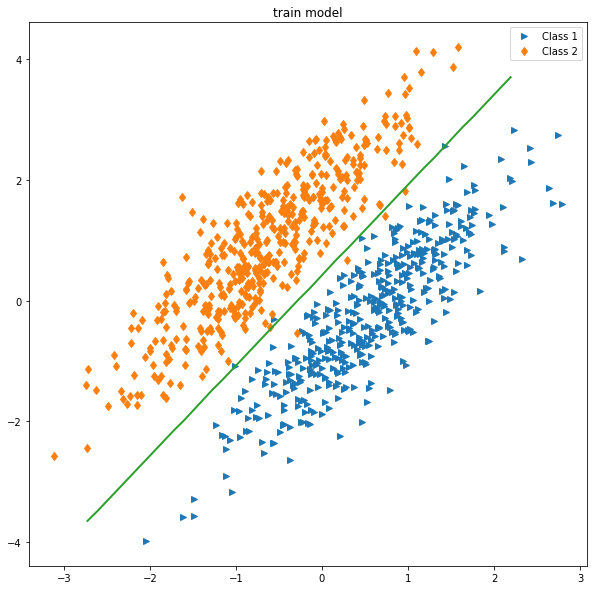

In [55]:
#plot train
fig, ax = plt.subplots(figsize=(10,10))
plotXY(X_train, Y_train,ax)
plot_border(lda, X_train,ax = ax)
ax.set_title('train model')
ax.legend(loc="best");

In [51]:
#metrics train
get_metrics(lda, X_train, Y_train)

True Positive 442
True Negative 452
False Positive 4
False Negative 2
Accuracy 0.9933333333333333
Precision 0.9910313901345291
Recall 0.9954954954954955
F1 Score 0.9932584269662922


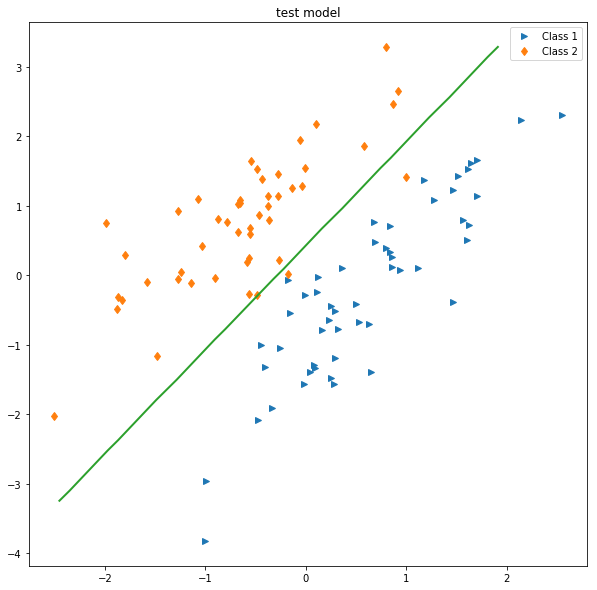

In [56]:
#plot test
fig, ax = plt.subplots(figsize=(10,10))
plotXY(X_test, Y_test,ax)
plot_border(lda, X_test,ax = ax)
ax.set_title('test model')
plt.legend(loc="best");

In [53]:
#metrics test
get_metrics(lda, X_test, Y_test)

True Positive 52
True Negative 46
False Positive 2
False Negative 0
Accuracy 0.98
Precision 0.9629629629629629
Recall 1.0
F1 Score 0.9811320754716981


# References

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis